In [1]:
import matplotlib.pyplot as plt
import numpy as np
from brian2.only import *
import seaborn as sns
import deepdish as dd
import scipy.stats as stats

import plot_utils as pu
from digest import conds, get_digest_output, get_voltages
import isi_indexing as ii
from readout import load_results
from digest import get_voltage_histograms

import conf.isi5_500 as cfg
from demonstrator import demonstrator

import styling

In [2]:
# on mouse:
import conf.isi5_mouse as cfm
cfg.fname = cfg.fname.replace(cfg.fbase, cfm.fbase)
cfg.netfile = cfg.netfile.replace(cfg.fbase, cfm.fbase)
cfg.digestfile = cfg.digestfile.replace(cfg.fbase, cfm.fbase)
cfg.fbase = cfm.fbase
cfg.raw_fbase = cfg.fname[:-3]


In [2]:
def index(n0, n1):
    return ((n0-n1)/(n0+n1))

In [3]:
def label(STD, TA):
    if STD and TA:
        return 'STD+TA'
    elif STD:
        return 'STD only'
    elif TA:
        return 'TA only'
    return 'no plasticity'

In [4]:
isi = cfg.ISIs[0]
templ = 0

In [7]:
nspikes = {STD: {TA: {cond: [] for cond in conds} for TA in cfg.TAs} for STD in cfg.STDs}
perneuron = {STD: {TA: {cond: [] for cond in conds} for TA in cfg.TAs} for STD in cfg.STDs}
for STD in cfg.STDs:
    for TA in cfg.TAs:
        for net in range(cfg.N_networks):
            res = load_results(cfg.fname.format(net=net, isi=isi, STD=STD, TA=TA, templ=templ), compress=True, process_dynamics=False)
            for ipair, pair in enumerate(cfg.pairings):
                for istim, stim in enumerate(pair):
                    for cond in conds:
                        data = res['spikes'][ipair][stim][cond]
                        nspikes[STD][TA][cond].append(data['nspikes'].sum(1).mean())
                        perneuron[STD][TA][cond].append(data['nspikes'].mean(0))
                        
        nspikes[STD][TA] = {cond: np.asarray(x) for cond, x in nspikes[STD][TA].items()}
        perneuron[STD][TA] = {cond: np.asarray(x) for cond, x in perneuron[STD][TA].items()}

In [6]:
dd.io.save('Fig5n-stats.h5', nspikes)
dd.io.save('Fig5n-stats.perneuron.h5', perneuron)

In [6]:
nspikes = dd.io.load('Fig5n-stats.h5')

In [7]:
indices = [('mismatch', 'dev', 'std'), ('adaptation', 'msc', 'std'), ('deviance detection', 'dev', 'msc')]


no plasticity
  mismatch > 0: t = nan, p = nan; 0/120
  adaptation > 0: t = nan, p = nan; 0/120
  deviance detection > 0: t = nan, p = nan; 0/120
  mismatch > adaptation: t = nan, p = nan; 0/120

TA only
* mismatch > 0: t = 9.9, p = 1.26e-17; 105/120
* adaptation > 0: t = 6.7, p = 3e-10; 94/120
* deviance detection > 0: t = 5.5, p = 1.01e-07; 95/120
* mismatch > adaptation: t = 5.4, p = 1.68e-07; 95/120

STD only
  mismatch > 0: t = 1.4, p = 0.0759; 67/120
* adaptation > 0: t = 3.2, p = 0.000983; 76/120
  deviance detection > 0: t = -1.9, p = 0.97; 59/120
  mismatch > adaptation: t = -2, p = 0.975; 59/120

STD+TA
* mismatch > 0: t = 11, p = 6.7e-21; 100/120
* adaptation > 0: t = 7.8, p = 1.05e-12; 92/120
* deviance detection > 0: t = 6.5, p = 1.05e-09; 92/120
* mismatch > adaptation: t = 6.2, p = 3.57e-09; 92/120


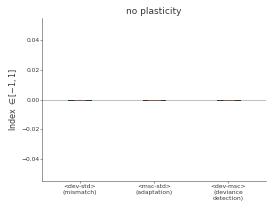

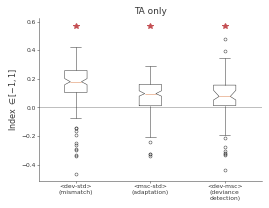

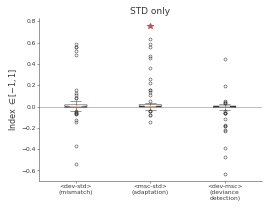

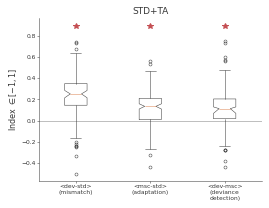

In [8]:
for STD in cfg.STDs:
    for TA in cfg.TAs:
        fig, ax = plt.subplots(figsize=(4,3))
        ax.axhline(0, color='grey', lw=1, alpha=.5)
        idx = [index(nspikes[STD][TA][i0], nspikes[STD][TA][i1]) for _, i0, i1 in indices]
        ax.boxplot(idx, notch=True, bootstrap=10000)
        newline = '\n'
        ax.set_xticks(range(1,4), [f'<{i0}-{i1}>\n({newline.join(title.split())})' for title, i0, i1 in indices])
        ax.set_ylabel('Index $\\in [-1,1]$')
        ax.set_title(label(STD, TA))

        imax = np.amax(idx)
        print(f'\n{label(STD, TA)}')
        for i, ix in enumerate(idx):
            test = stats.ttest_1samp(ix, 0, alternative='greater')
            print(f'{"*" if test.pvalue < .05 else " "} {indices[i][0]} > 0: t = {test.statistic:.2g}, p = {test.pvalue:.3g}; '
                  f'{np.sum(ix>0)}/{ix.size}')
            if test.pvalue < .05:
                ax.plot(i+1, 1.2*imax, 'r*')
        test = stats.ttest_rel(idx[0], idx[1], alternative='greater')
        print(f'{"*" if test.pvalue < .05 else " "} {indices[0][0]} > {indices[1][0]}: t = {test.statistic:.2g}, p = {test.pvalue:.3g}; '
              f'{np.sum(idx[0] > idx[1])}/{idx[0].size}')
        
        sns.despine()


<dev-std>
(mismatch)
  no plasticity < STD only: t = -1.4, p = 0.0759
* no plasticity < TA only: t = -9.9, p = 1.26e-17
* no plasticity < STD+TA: t = -11, p = 6.7e-21
* STD only < TA only: t = -6.8, p = 1.83e-10
* STD only < STD+TA: t = -11, p = 7.65e-20
* TA only < STD+TA: t = -5, p = 9.28e-07
* STD+TA > (sum of partials): t = 4.2, p = 2.18e-05

<msc-std>
(adaptation)
* no plasticity < STD only: t = -3.2, p = 0.000983
* no plasticity < TA only: t = -6.7, p = 3e-10
* no plasticity < STD+TA: t = -7.8, p = 1.05e-12
* STD only < TA only: t = -2.3, p = 0.0111
* STD only < STD+TA: t = -4.3, p = 2.11e-05
* TA only < STD+TA: t = -2.9, p = 0.00203
  STD+TA > (sum of partials): t = 0.3, p = 0.381

<dev-msc>
(deviance detection)
  no plasticity < STD only: t = 1.9, p = 0.97
* no plasticity < TA only: t = -5.5, p = 1.01e-07
* no plasticity < STD+TA: t = -6.5, p = 1.05e-09
* STD only < TA only: t = -5.7, p = 4.67e-08
* STD only < STD+TA: t = -6.7, p = 4.53e-10
* TA only < STD+TA: t = -3.2, p = 0.

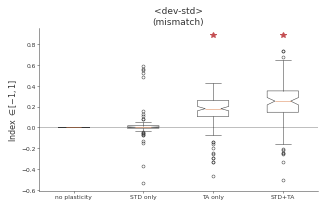

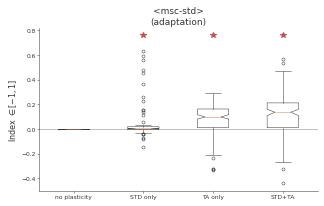

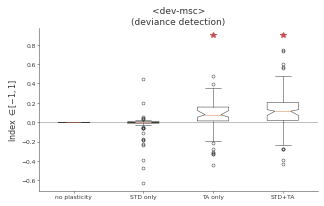

In [9]:
plasticity = [(TA, STD) for TA in cfg.TAs for STD in cfg.STDs]
for title, n0, n1 in indices:
    idx = [index(nspikes[STD][TA][n0], nspikes[STD][TA][n1]) for TA, STD in plasticity]
    fig, ax = plt.subplots(figsize=(5,3))
    ax.axhline(0, color='grey', lw=1, alpha=.5)
    ax.boxplot(idx, notch=True, bootstrap=10000)
    ax.set_xticks(range(1,5), [label(STD, TA) for TA, STD in plasticity])
    ax.set_ylabel('Index $\\in [-1,1]$')
    ax.set_title(f'<{n0}-{n1}>\n({title})')
    sns.despine()

    imax = np.amax(idx)
    for i, ix in enumerate(idx):
        test = stats.ttest_1samp(ix, 0, alternative='greater')
        if test.pvalue < .05:
            ax.plot(i+1, 1.2*imax, 'r*')

    h = .05*np.amax(idx)
    print(f'\n<{n0}-{n1}>\n({title})')
    for i, (t0, s0) in enumerate(plasticity):
        i0 = index(nspikes[s0][t0][n0], nspikes[s0][t0][n1])
        for j, (t1, s1) in enumerate(plasticity[i+1:]):
            j += i+1
            i1 = index(nspikes[s1][t1][n0], nspikes[s1][t1][n1])
            test = stats.ttest_rel(i0, i1, alternative='less')
            print(f'{"*" if test.pvalue < .05 else " "} {label(s0,t0)} < {label(s1,t1)}: t = {test.statistic:.2g}, p = {test.pvalue:.3g}')

    ifull = index(nspikes[1][1][n0], nspikes[1][1][n1])
    isum = sum([index(nspikes[STD][TA][n0], nspikes[STD][TA][n1]) for STD, TA in plasticity[1:-1]])
    test = stats.ttest_rel(ifull, isum, alternative='greater')
    print(f'{"*" if test.pvalue < .05 else " "} {label(1,1)} > (sum of partials): t = {test.statistic:.2g}, p = {test.pvalue:.3g}')